# Spark Connector with PySpark
In the examples that follows, we will be using the Spark Connector running under PySpark
[Neo4j spark connector under Python](https://neo4j.com/docs/spark/current/python/)
Please run this notebook from a valid Spark environment.  It was tested under [EMR](https://aws.amazon.com/emr/).

## Setup Neo4j instance
Create a free account at https://sandbox.neo4j.com. Choose the “Blank Sandbox - Graph Data Science” option.
When your sandbox has been created, fill in the Bolt URL and password below.

## Environment Setup

In [ ]:
pip install --upgrade seaborn

In [ ]:
pip install --upgrade matplotlib

## Setup Neo4j Spark Connector imports

In [2]:
from pyspark.sql import SparkSession
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

Define Neo4j connection variables

In [3]:
neo4j_url = "bolt://<ip>:7687"
neo4j_user = "neo4j"
neo4j_password = "<pwd>"
neo4j_database= "neo4j"

Create Spark Session, seeded with Neo4j packages.  If you don't want to wait for the download each time, load the connector into the master node using SSH.

In [4]:
spark = (SparkSession.builder
        .appName('Leverage Neo4j with Apache Spark')
        .master('local[*]')
        # Just to show dataframes as tables
        .config('spark.sql.repl.eagerEval.enabled', True)
        .config('spark.jars.packages', 'org.neo4j:neo4j-connector-apache-spark_2.12:4.1.3_for_spark_2.4')       
        .config("neo4j.url", neo4j_url)
        .config("neo4j.authentication.type", "basic")
        .config("neo4j.authentication.basic.username", neo4j_user)
        .config("neo4j.authentication.basic.password", neo4j_password)
        .getOrCreate())
# output spark version
spark

Here we are going to create a utility class for the Spark Connector.  Some valid cypher statements will not run in the Spark Connector, as cypher.  They must be executed as side effects through the "script" argument of a dummy write operation.

In [84]:
class SparkConnector:
    
    def __init__( self, spark_session, uri, user, pwd):
        
        self.__spark_session = spark_session
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__count_cypher = "MATCH (n) RETURN count(n)"
        self.__no_side_effects = "MATCH (n) WHERE 1 = 2 SET n.placeholder = false"
        self.__df = self.read_cypher(self.__count_cypher)
            
    def read_cypher(self, query):
        
        response = None
        try: 
            response = self.__spark_session.read.format("org.neo4j.spark.DataSource") \
                .option("query", query) \
                .option("url", self.__uri) \
                .option("authentication.type", "basic") \
                .option("authentication.basic.username", self.__user) \
                .option("authentication.basic.password", self.__pwd) \
                .option("partitions", "1") \
                .load()
        except Exception as e:
            print("Read query failed:", e)

        return response
    
    def write_cypher(self, query):
        
        response = None
        try: 
            response = self.__df.write.format("org.neo4j.spark.DataSource") \
                .option("query", query) \
                .option("url", self.__uri) \
                .option("authentication.type", "basic") \
                .option("authentication.basic.username", self.__user) \
                .option("authentication.basic.password", self.__pwd) \
                .option("partitions", "1") \
                .save()
        except Exception as e:
            print("Write query failed:", e)

        return response
    
    def write_script(self,cypher):
        
        response = None
        try: 
            response = self.__df.write.format("org.neo4j.spark.DataSource") \
              .option("url", self.__uri) \
              .option("authentication.type", "basic") \
              .option("authentication.basic.username", self.__user) \
              .option("authentication.basic.password", self.__pwd) \
              .option("query", self.__no_side_effects) \
              .option("script",cypher) \
              .option("partitions", "1") \
              .save()
        except Exception as e:
            print("Write query failed:", e)

        return response
     

             

Let's now check that GDS is running on the server by executing this Cypher query.
We only need to supply credentials once per notebook.

In [85]:
sparkConnector = SparkConnector(spark_session=spark,uri=neo4j_url, user=neo4j_user, pwd=neo4j_password)

In [33]:
df=sparkConnector.read_cypher("return gds.version() as gds_version")
df.show();

+-----------+
|gds_version|
+-----------+
|      2.0.1|
+-----------+



In [116]:
sparkConnector.read_cypher("MATCH (n:MSA) RETURN count(n)").show()

+--------+
|count(n)|
+--------+
|     392|
+--------+



Optional if database is not empty!  Reset it!

In [34]:
reset_db_query = """CREATE OR REPLACE DATABASE `neo4j`"""
sparkConnector.write_script(reset_db_query)

Check that it's empty now.

In [35]:
sparkConnector.read_cypher("MATCH (n:MSA) RETURN count(n)").show()

+--------+
|count(n)|
+--------+
|       0|
+--------+



# Load MSA data

Create unique constraint on MSA

In [1]:
sparkConnector.write_script("""
CREATE CONSTRAINT msa_name IF NOT EXISTS ON (m:MSA) ASSERT m.name IS NODE KEY
""")

NameError: name 'sparkConnector' is not defined

Load CSV data

In [36]:
load_csv_query = """
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/smithna/datasets/main/CensusDemographicsByMetroArea.csv' 
AS row
WITH row WHERE row.name CONTAINS 'Metro'
MERGE (m:MSA {name:row.name})
SET m.population = toInteger(row.population),
m.medianHouseholdIncome = toInteger(row.medianHouseholdIncome),
m.medianHomePrice = toInteger(row.medianHomePrice),
m.percentOver25WithBachelors = toFloat(row.percentOver25WithBachelors)
RETURN count(m) as msaCount"""

sparkConnector.write_script(load_csv_query)

In [37]:
msa_df_query = """
MATCH (m:MSA)
RETURN m.name AS msa, 
m.population AS population,
m.medianHouseholdIncome AS medianHouseholdIncome,
m.medianHomePrice AS medianHomePrice,
m.percentOver25WithBachelors as percentOver25WithBachelors"""

msa_df=sparkConnector.read_cypher(msa_df_query)
msa_df.show()

+--------------------+----------+---------------------+---------------+--------------------------+
|                 msa|population|medianHouseholdIncome|medianHomePrice|percentOver25WithBachelors|
+--------------------+----------+---------------------+---------------+--------------------------+
|Abilene, TX Metro...|    170669|                52511|         142900|                      23.0|
|Aguadilla-Isabela...|    301107|                16470|         126000|                      20.7|
|Akron, OH Metro Area|    703845|                57285|         156800|                      31.7|
|Albany, GA Metro ...|    148436|                44844|         131700|                      20.0|
|Albany-Lebanon, O...|    125048|                55893|         224800|                      19.3|
|Albany-Schenectad...|    880736|                71285|         222500|                      37.5|
|Albuquerque, NM M...|    912108|                54072|         197200|                      32.2|
|Alexandri

Convert Spark dataframe to pandas to display histogram

In [38]:
pandas_msa_df=msa_df.toPandas()
print(pandas_msa_df)

                                              msa  population  \
0                          Abilene, TX Metro Area      170669   
1                Aguadilla-Isabela, PR Metro Area      301107   
2                            Akron, OH Metro Area      703845   
3                           Albany, GA Metro Area      148436   
4                   Albany-Lebanon, OR Metro Area      125048   
..                                            ...         ...   
387                          Yauco, PR Metro Area       90618   
388                   York-Hanover, PA Metro Area      445565   
389  Youngstown-Warren-Boardman, OH-PA Metro Area      541846   
390                      Yuba City, CA Metro Area      172469   
391                           Yuma, AZ Metro Area      209468   

     medianHouseholdIncome  medianHomePrice  percentOver25WithBachelors  
0                    52511           142900                        23.0  
1                    16470           126000                        20.7

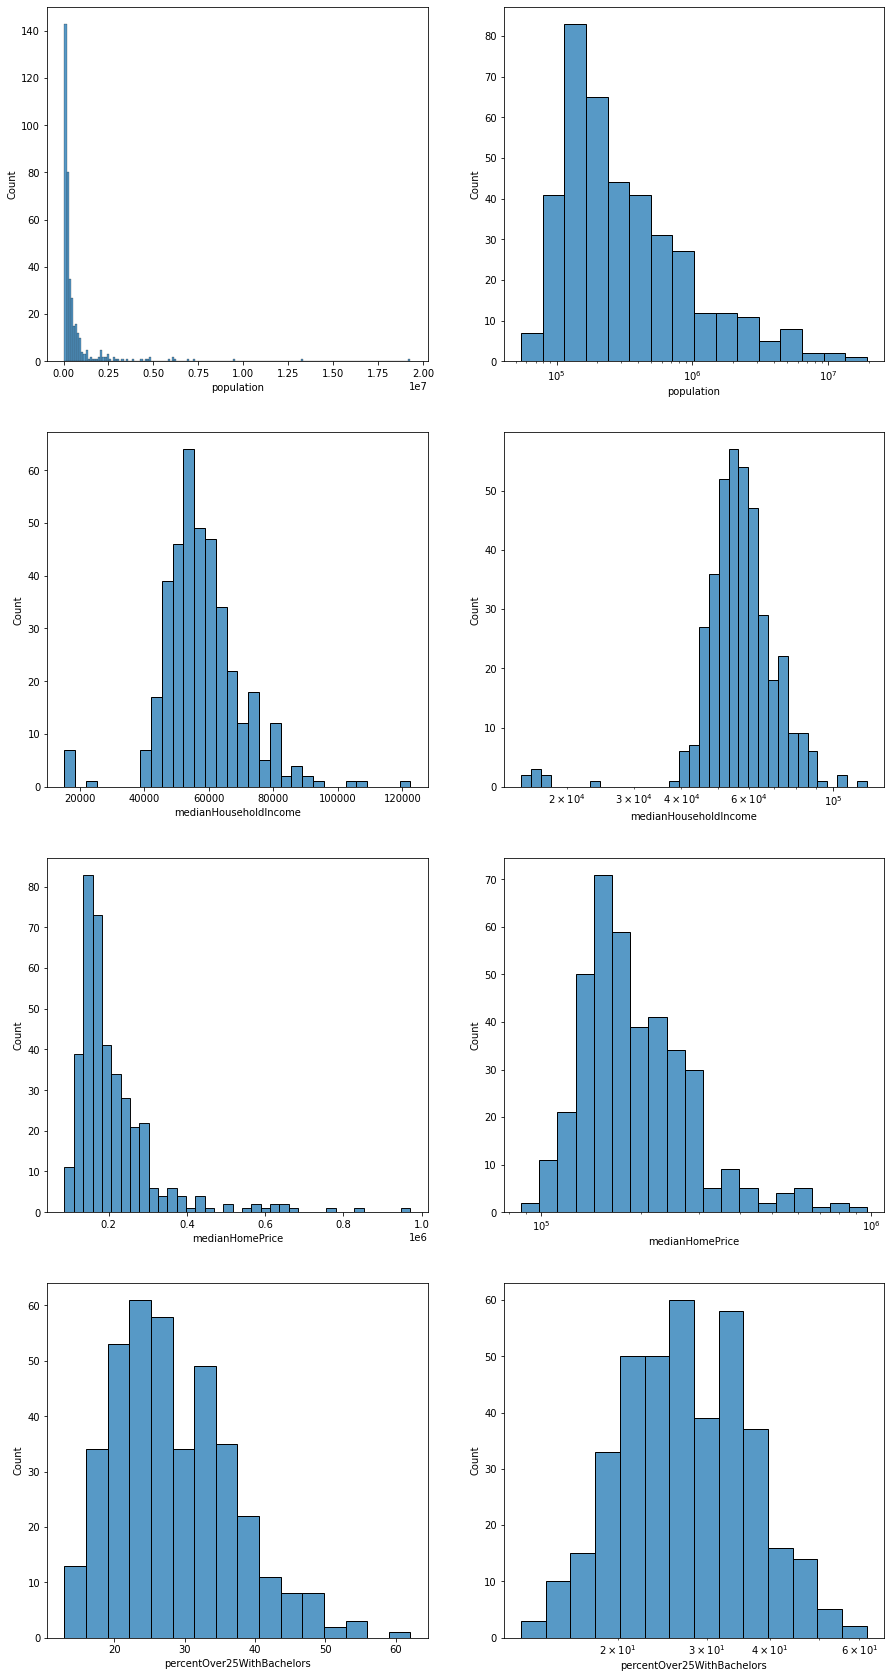

In [39]:
fig, axes = plt.subplots(4, 2)
fig.set_size_inches(15,30)
for i in range(1,5):
    sns.histplot(pandas_msa_df.iloc[:,i], ax=axes[i-1,0])
    sns.histplot(pandas_msa_df.iloc[:, i], log_scale=True, ax=axes[i-1,1])

That log transformation looks like it will help. Run the Cypher to store the transformed values in the graph.

In [40]:
msa_df_update_query = """
MATCH (m:MSA)
SET 
m.logPopulation = log(m.population),
m.logMedianHouseholdIncome = log(m.medianHouseholdIncome),
m.logMedianHomePrice = log(m.medianHomePrice),
m.logPercentOver25WithBachelors = log(m.percentOver25WithBachelors)
"""

sparkConnector.write_cypher(msa_df_update_query)

Check that logs were committed to the database

In [41]:
msa_df_log_query = """
MATCH (m:MSA)
RETURN m.name AS msa, 
m.population AS population,
m.logPopulation,
m.medianHouseholdIncome AS medianHouseholdIncome
"""

msa_df = sparkConnector.read_cypher(msa_df_log_query)

msa_df.show()

+--------------------+----------+------------------+---------------------+
|                 msa|population|   m.logPopulation|medianHouseholdIncome|
+--------------------+----------+------------------+---------------------+
|Abilene, TX Metro...|    170669|12.047481287135076|                52511|
|Aguadilla-Isabela...|    301107|12.615220962289929|                16470|
|Akron, OH Metro Area|    703845|13.464313440444561|                57285|
|Albany, GA Metro ...|    148436| 11.90790916789688|                44844|
|Albany-Lebanon, O...|    125048|11.736452942575307|                55893|
|Albany-Schenectad...|    880736|13.688513200533578|                71285|
|Albuquerque, NM M...|    912108|13.723513683097881|                54072|
|Alexandria, LA Me...|    153310|  11.9402172943045|                46367|
|Allentown-Bethleh...|    837610|13.638307877340166|                67652|
|Altoona, PA Metro...|    123157|11.721215243183789|                49181|
|Amarillo, TX Metr...|   

## Create in-memory graph projection
Passing `"*"` as the third argument to `gds.graph.project` tells GDS to include any relationships that exist in the database in the in-memory graph. Because no relationships have been created in the graph yet, there will be no relationships in the in-memory graph projection when it is created.

In [42]:
graph_project_query = """
    CALL gds.graph.project(
    'msa-graph', 
    'MSA', 
    '*', 
    {nodeProperties: ["logPopulation", 
        "logMedianHouseholdIncome", 
        "logMedianHomePrice", 
        "logPercentOver25WithBachelors"]})
"""

sparkConnector.write_script(graph_project_query)


## Apply MinMax scalar to property values

In [43]:
graph_scale_properties_mutations = """
CALL gds.alpha.scaleProperties.mutate("msa-graph", {
                                 nodeProperties: [
                                     "logPopulation", 
                                     "logMedianHouseholdIncome", 
                                     "logMedianHomePrice", 
                                     "logPercentOver25WithBachelors"], 
                                 scaler : "MinMax",
                                 mutateProperty : "scaledProperties"
                                 })
                                 """

sparkConnector.write_script(graph_scale_properties_mutations)

This next line streams node properties to the procedure caller.

<AxesSubplot:>

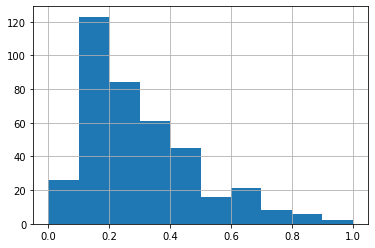

In [44]:
graph_stream_scaled_properties_query = """
CALL gds.graph.streamNodeProperty('msa-graph', 'scaledProperties')
YIELD nodeId, propertyValue
RETURN nodeId, propertyValue
                                 """
sp_df = sparkConnector.read_cypher(graph_stream_scaled_properties_query)

pandas_sp_df=sp_df.toPandas()
pd.DataFrame(list(pandas_sp_df['propertyValue'])).iloc[:,0].hist()

Cleanup resources

<AxesSubplot:>

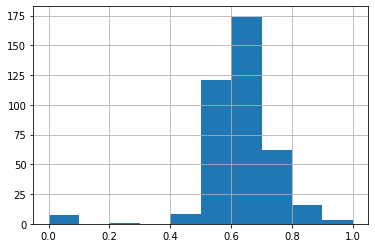

In [45]:
pd.DataFrame(list(pandas_sp_df['propertyValue'])).iloc[:,1].hist()

<AxesSubplot:>

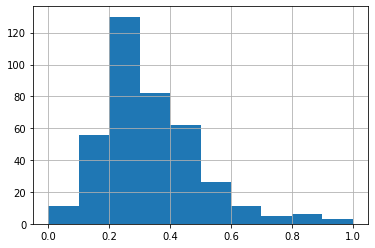

In [46]:
pd.DataFrame(list(pandas_sp_df['propertyValue'])).iloc[:,2].hist()

<AxesSubplot:>

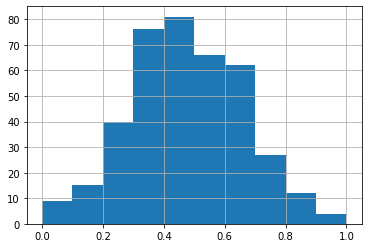

In [47]:
pd.DataFrame(list(pandas_sp_df['propertyValue'])).iloc[:,3].hist()

Run KNN to create relationships to nearest neighbors
First run in stats mode and look at the similarity distribution.

In [53]:
knn_stats_query = """CALL gds.knn.stats("msa-graph",
   {
      nodeProperties:{
      scaledProperties:"EUCLIDEAN"},
      topK:15,
      similarityCutoff: 0.8350143432617188,
      sampleRate:1,
      randomSeed:42,
      concurrency:1
   }
) 
YIELD similarityDistribution 
RETURN similarityDistribution """
                                    
knn_stats=sparkConnector.read_cypher(knn_stats_query)
knn_stats.collect()[0]

Row(similarityDistribution={'p1': 0.88128662109375, 'p5': 0.9450721740722656, 'max': 0.9999847412109375, 'p90': 0.9963340759277344, 'p50': 0.9896583557128906, 'p95': 0.9976234436035156, 'p10': 0.9648170471191406, 'p75': 0.993865966796875, 'p99': 0.998992919921875, 'p100': 0.9999847412109375, 'p25': 0.9818534851074219, 'min': 0.8350143432617188, 'mean': 0.9832137070829129, 'stdDev': 0.020862493999870387})

Write KNN nearest neighbors

In [57]:
knn_write = f"""CALL gds.knn.mutate("msa-graph",
               {{nodeProperties: {{scaledProperties: "EUCLIDEAN"}},
               topK: 15,
               mutateRelationshipType: "IS_SIMILAR",
               mutateProperty: "similarity",
               similarityCutoff: {knn_stats.collect()[0]['similarityDistribution']['p1']},
               sampleRate:1,
               randomSeed:42,
               concurrency:1}}
              ) """

#print(knn_write)
sparkConnector.write_script(knn_write)

CALL gds.knn.mutate("msa-graph",
               {nodeProperties: {scaledProperties: "EUCLIDEAN"},
               topK: 15,
               mutateRelationshipType: "IS_SIMILAR",
               mutateProperty: "similarity",
               similarityCutoff: 0.88128662109375,
               sampleRate:1,
               randomSeed:42,
               concurrency:1}
              ) 


Write back to Neo4j graph

In [58]:
similarity_relationship_writeback = """CALL gds.graph.writeRelationship(
    "msa-graph",
    "IS_SIMILAR",
    "similarity"
)"""

sparkConnector.write_script(similarity_relationship_writeback)

Add rank updates

In [59]:
add_rank_update = """
MATCH (m:MSA)-[s:IS_SIMILAR]->()
WITH m, s ORDER BY s.similarity DESC
WITH m, collect(s) as similarities, range(0, 11) AS ranks
UNWIND ranks AS rank
WITH rank, similarities[rank] AS rel
SET rel.rank = rank + 1
"""

sparkConnector.write_cypher(add_rank_update)

## Run Louvain Community Detection

See how many communities Louvain is going to recommend

In [28]:
read_louvain = """
CALL gds.louvain.stats('msa-graph',
{relationshipTypes: ["IS_SIMILAR"],
relationshipWeightProperty:"similarity"})
YIELD communityCount, modularities
RETURN communityCount, modularities
"""
sparkConnector.read_cypher(read_louvain).show()

+--------------+--------------------+
|communityCount|        modularities|
+--------------+--------------------+
|            15|[0.6275570163412072]|
+--------------+--------------------+



Now commit louvain communities to database

In [62]:
write_louvain = """
CALL gds.louvain.write('msa-graph',
{relationshipTypes: ["IS_SIMILAR"],
relationshipWeightProperty:"similarity",
 writeProperty:"communityId"})
YIELD communityCount, modularities
RETURN communityCount, modularities
"""

sparkConnector.write_cypher(write_louvain)

In [96]:
community_query = """
MATCH (m:MSA)
WITH m 
ORDER BY apoc.coll.sum([(m)-[s:IS_SIMILAR]->(m2) 
WHERE m.communityId = m2.communityId | s.similarity]) desc
RETURN m.communityId as communityId,
count(m) as msaCount, 
avg(m.population) as avgPopulation,
avg(m.medianHomePrice) as avgHomePrice,
avg(m.medianHouseholdIncome) as avgIncome,
avg(m.percentOver25WithBachelors) as avgPctBachelors,
collect(m.name)[..3] as exampleMSAs
"""

## Removed final sort because this doesn]t work with Spark 
## ORDER BY avgPopulation DESC
## post sorting in spark
                                      
community_df=sparkConnector.read_cypher(community_query).sort("avgPopulation")

In [97]:
pd_community_df=community_df.toPandas()
pd_community_df

,communityId,msaCount,avgPopulation,avgHomePrice,avgIncome,avgPctBachelors,exampleMSAs
0,266,63,1.336109e+05,150033.333333,52001.047619,22.025397,"[Lawton, OK Metro Area, Watertown-Fort Drum, N..."
1,313,7,1.569859e+05,113228.571429,16556.857143,22.400000,"[San Germán, PR Metro Area, Arecibo, PR Metro ..."
2,100,41,1.612953e+05,161904.878049,49128.707317,16.965854,"[Anniston-Oxford, AL Metro Area, Gadsden, AL M..."
3,277,71,1.754926e+05,237325.352113,61466.591549,35.415493,"[Pittsfield, MA Metro Area, Blacksburg-Christi..."
4,254,53,2.334595e+05,167798.113208,55711.245283,26.894340,"[Tyler, TX Metro Area, South Bend-Mishawaka, I..."
5,333,28,4.606980e+05,149510.714286,48965.928571,21.325000,"[Flint, MI Metro Area, Corpus Christi, TX Metr..."
6,56,79,1.678945e+06,203273.417722,60116.164557,31.040506,"[Little Rock-North Little Rock-Conway, AR Metr..."
7,83,49,1.916216e+06,411930.612245,78436.734694,39.248980,"[Colorado Springs, CO Metro Area, Oxnard-Thous..."
8,315,1,2.100207e+06,140600.000000,23156.000000,28.000000,"[San Juan-Bayamón-Caguas, PR Metro Area]"


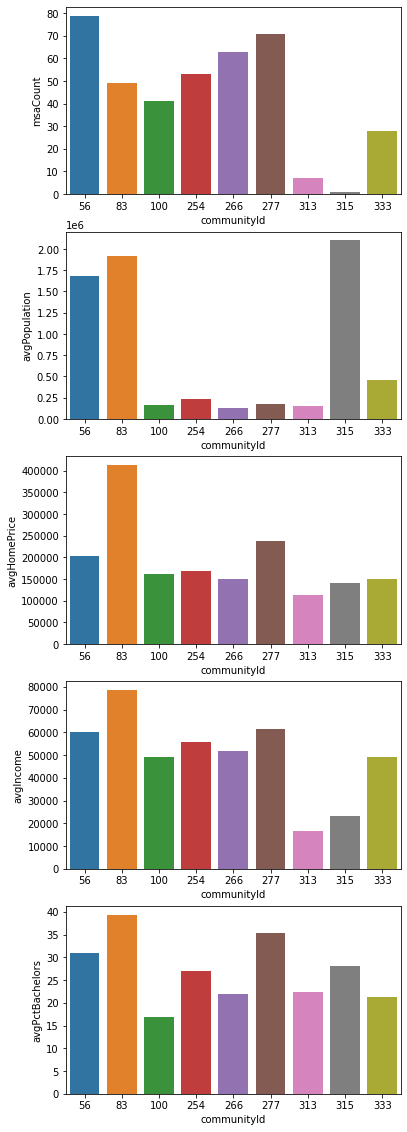

In [98]:
fig, axes = plt.subplots(5, 1)
fig.set_size_inches(6,20)
for i in range(1,6):
    sns.barplot(data=pd_community_df, x="communityId", y=pd_community_df.columns[i], ax=axes[i-1])

Mean can give us a quick overview of properties, but can be skewed by outliers. Compare emperical cumulative distribution function (ECDF) at various proportions to get a more complete picture of distributions.

In [99]:
# we need to remove sort by here
detail_query="""
MATCH (m:MSA)
RETURN "community " + m.communityId as communityId,
m.population as population,
m.medianHomePrice as medianHomePrice,
m.medianHouseholdIncome as medianIncome,
m.percentOver25WithBachelors as pctBachelors
"""

## post sorting in spark

detail_df=sparkConnector.read_cypher(detail_query).sort("communityId")


In [101]:
pd_detail_df=detail_df.toPandas()
pd_detail_df

,communityId,population,medianHomePrice,medianIncome,pctBachelors
0,community 100,148436,131700,44844,20.0
1,community 100,153310,154500,46367,19.0
2,community 100,114618,133800,47255,18.5
3,community 100,104104,104100,48819,19.3
4,community 100,118828,121000,42817,17.1
...,...,...,...,...,...
387,community 83,367922,291100,81057,42.6
388,community 83,984821,673400,85857,35.0
389,community 83,441829,419700,81472,26.9
390,community 83,6196585,425300,103751,50.9


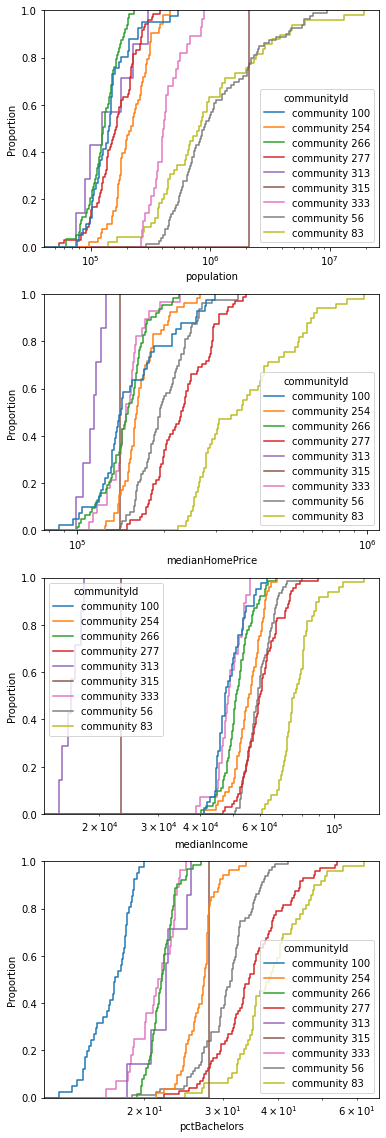

In [103]:
fig, axes = plt.subplots(4, 1)
fig.set_size_inches(6,20)
for i in range(1,5):
    sns.ecdfplot(data=pd_detail_df, hue="communityId", x=pd_detail_df.columns[i], log_scale=True, ax=axes[i-1])

Compare two-dimensions on scatter plots

[None]

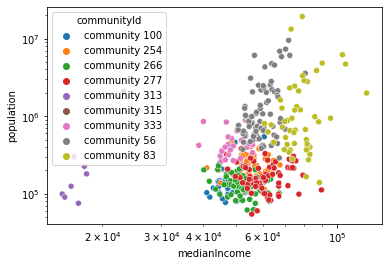

In [104]:
splot = sns.scatterplot(data=pd_detail_df, x="medianIncome", y="population", hue="communityId")
splot.set(yscale="log")
splot.set(xscale="log")

[None]

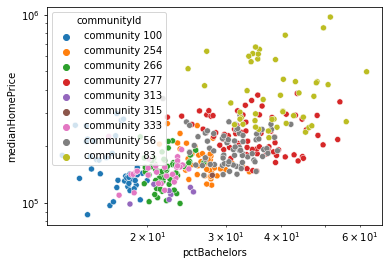

In [105]:
splot = sns.scatterplot(data=pd_detail_df, x="pctBachelors", y="medianHomePrice", hue="communityId")
splot.set(yscale="log")
splot.set(xscale="log")

## Optional: assign human-friendly names to the clusters discovered.
The Louvain community detection algorithm is not deterministic. You should have roughly the same clusters from previous runs, but some edge cases might be assigned to different communities. The community numbers might be shuffled between across different runs.  
**This step requires adjustment by hand: choose from community IDs above.**

In [113]:
update_community_name_query="""
MATCH (m:MSA) 
  SET m.communityName = CASE m.communityId 
  WHEN 56 THEN "Large mid-cost metros"
  WHEN 83 THEN "College towns"
  WHEN 254 THEN "Large high-cost metros"
  WHEN 266 THEN "Mid-size metros"
  WHEN 277 THEN "Small metros"
  WHEN 315 THEN "Mid-price metros"
  WHEN 333 THEN "Low-income metros"
  END
"""

sparkConnector.write_cypher(update_community_name_query)

Check on updates

In [114]:
describe_query="""
MATCH (m:MSA)
return m.communityName, m.communityId, count(*)
"""

sparkConnector.read_cypher(describe_query)

m.communityName,m.communityId,count(*)
Mid-size metros,266,63
null,313,7
Large mid-cost me...,56,79
null,100,41
College towns,83,49
Large high-cost m...,254,53
Small metros,277,71
Low-income metros,333,28
Mid-price metros,315,1


Create an index on the communityName property to make it searchable in Bloom.

In [115]:
sparkConnector.write_script("""
CREATE INDEX msa_community_name IF NOT EXISTS
FOR (m:MSA) ON (m.communityName)
""")

Now open Bloom and do some additional analysis!

## Cleanup

In [ ]:
graph_project_drop = """
    CALL gds.graph.drop(
    'msa-graph')
"""
sparkConnector.write_script(graph_project_drop)